# Conv4 3D Residual v2

### Here we compare different approaches to training the network
### and visualize performance of the network on validation set for different signal classes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import os, re, gc
import h5py
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

#os.environ["CUDA_VISIBLE_DEVICES"] = '0'
#from cnn_utils import *

In [2]:
def bckg_rej(a_true, a_pred, thresh = 0.5):
    a_true = np.array(a_true, dtype=bool)
    #if tpfp<1: print('nothing positive, thresh:',thresh)
    return np.invert(a_true).sum()/((a_pred>thresh)[np.invert(a_true)]).sum()

def precise(a_true, a_pred, thresh = 0.5):
    a_true = np.array(a_true, dtype=bool)
    #if tpfp<1: print('nothing positive, thresh:',thresh)
    return ((a_pred>thresh)[a_true]).sum()/(a_pred>thresh).sum()

def accurate(a_true, a_pred, thresh = 0.5):
    a_true = np.array(a_true, dtype=bool)
    tp = ((a_pred>thresh)[a_true]).sum()
    tn = ((a_pred<thresh)[np.invert(a_true)]).sum()
    return (tp+tn)/len(a_true)

def efficiate(a_true, a_pred, thresh = 0.5):
    a_true = np.array(a_true, dtype=bool)
    return ((a_pred>thresh)[a_true]).sum()/np.sum(a_true)

def rej_eff_curve(y_true, y_pred, thresh_curve):
    return [bckg_rej(y_true, y_pred, th) for th in thresh_curve], [efficiate(y_true, y_pred, th) for th in thresh_curve]

def pos_neg(y, preds):
    pos = np.array([[],[]]).T
    neg = np.array([[],[]]).T
    preds = np.ravel(preds)
    for i,grek in enumerate(y):
        if grek:
            pos = np.vstack((pos, np.array([preds[i],i])))
        else:
            neg = np.vstack((neg, [preds[i],i]))
    gc.collect()
    return pos, neg

In [3]:
N_ep = 10; batch = 256; i=0; n_fold = 4
class_names = ['C100keV','C60keV','C30keV']
train_types = ['rot','no_rot']
load_s = []
for n in class_names:
    load_s += [(n+'-'+str(i)) for i in range(1,n_fold+1)]
#dset = '/mnt/ML-drive/Artem/Python/NEWS/data/dataset_phys_clean.h5'

In [4]:
preds = {}
for tr in train_types:
    for n in class_names:
        for s in load_s:
            preds[n+'_'+s+'_'+tr] = np.loadtxt('fog/outputs/conv4_3d_res/v2/preds/'+tr+'/'+'e'+str(N_ep)+'_'+n+'_'+s+'.txt')

In [5]:
preds['C100keV_C100keV-1_rot']

array([[3.68848778e-05, 0.00000000e+00],
       [2.92297520e-10, 0.00000000e+00],
       [9.99995947e-01, 1.00000000e+00],
       ...,
       [9.99991059e-01, 1.00000000e+00],
       [9.99996543e-01, 1.00000000e+00],
       [9.99990940e-01, 1.00000000e+00]])

In [14]:
'''threshs = {}
for n in class_names:
    for s in preds.keys():
        if not s.startswith(n) or n in threshs.keys(): continue
        threshs[n] = precision_recall_curve(preds[s][:,1], preds[s][:,0])[2][:-1]'''
pr_curves, min_eff, interp = {},{},{}
thr_curves, min_thr, inter_thr = {},{},{}
for n in class_names: min_eff[n] = 0.6
thresh = 1-np.logspace(1,8,num=40,base=5)**-1
for tr in train_types:
    for n in class_names:
        for s in load_s:
            if not s.startswith(n): continue
            rej, eff, th = roc_curve(preds[n+'_'+s+'_'+tr][:,1],preds[n+'_'+s+'_'+tr][:,0])
            rej = rej**-1
            sort_ind = np.argsort(eff)
            interp[n+'_'+s+'_'+tr] = sp.interpolate.interp1d(eff, rej, fill_value='extrapolate')
            if eff[sort_ind[0]]>min_eff[n]: min_eff[n] = eff[sort_ind[0]]

pr_curves['class'], pr_curves['bckg_rejection'], pr_curves['efficiency'], pr_curves['type'], pr_curves['model'] = [],[],[],[],[]
thr_curves['class'], thr_curves['bckg_rejection'], thr_curves['inv_threshold'], thr_curves['type'], thr_curves['model'] = [],[],[],[],[]
for tr in train_types:
    for n in class_names:
        for s in load_s:
            if not s.startswith(n): continue
            #eff = min_eff[n] + (np.sort(np.logspace(1,8,num=100,base=2)**-1)*2*(1-min_eff[n]))[:-1]
            eff = np.linspace(min_eff[n],1,1000)
            pr_curves['class'] += [n]*len(eff)
            pr_curves['efficiency'] += list(eff)
            pr_curves['bckg_rejection'] += list(interp[n+'_'+s+'_'+tr](eff))
            pr_curves['model'] += [s[:-2]]*len(eff)
            pr_curves['type'] += [tr]*len(eff)
            rej, eff = rej_eff_curve(preds[n+'_'+s+'_'+tr][:,1],preds[n+'_'+s+'_'+tr][:,0],thresh)
            thr_curves['class'] += [n]*len(eff)
            thr_curves['inv_threshold'] += list((1-thresh))
            thr_curves['bckg_rejection'] += rej
            thr_curves['model'] += [s[:-2]]*len(eff)
            thr_curves['type'] += [tr]*len(eff)
pr_curves = pd.DataFrame(data=pr_curves)
thr_curves = pd.DataFrame(data=thr_curves)
_ = gc.collect()

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in reciprocal
  from ipykernel import kernelapp as app
/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  after removing the cwd from sys.path.


In [18]:
gc.collect()

11766

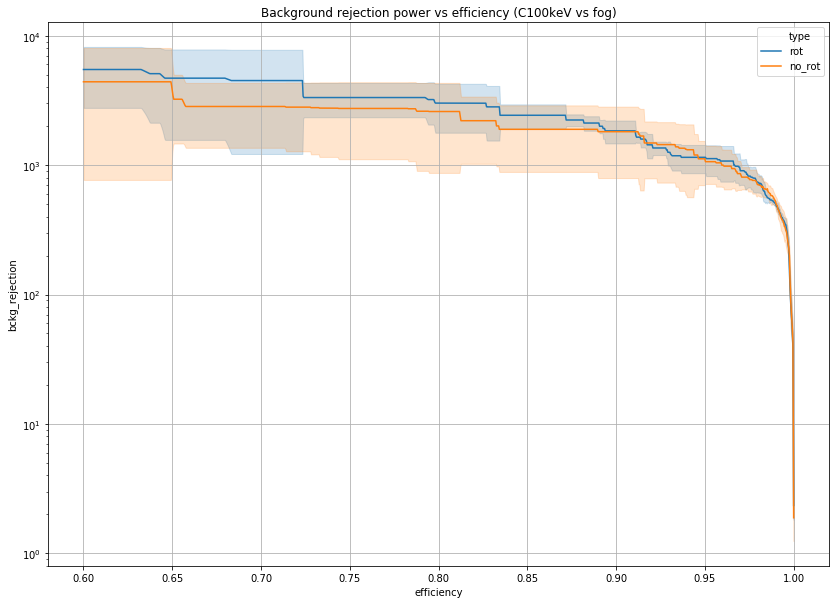




If we call inverse_threshold = 1-threshold to explore the region of probability threshold close to 1




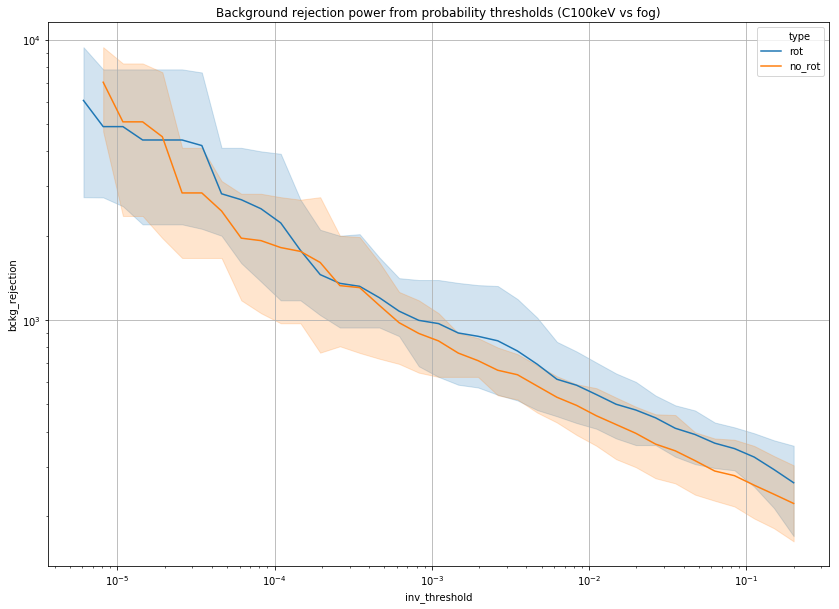

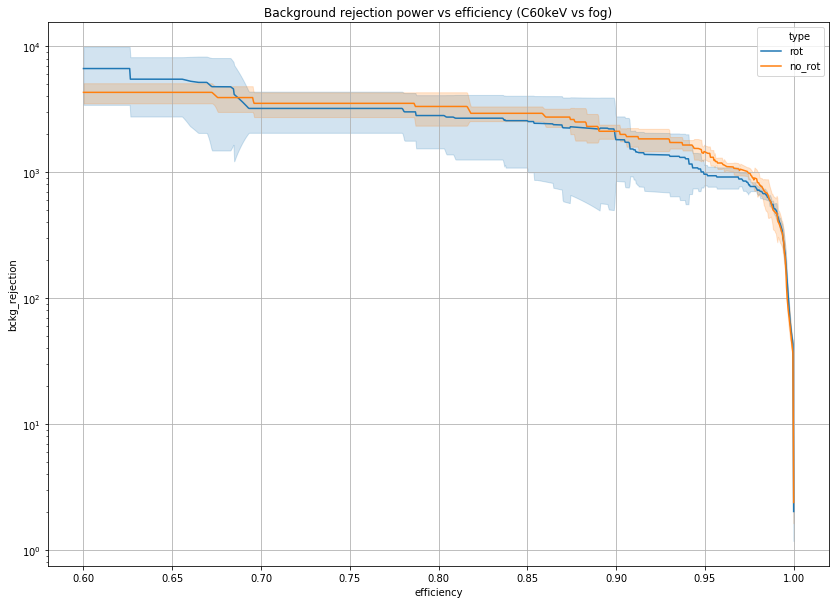




If we call inverse_threshold = 1-threshold to explore the region of probability threshold close to 1




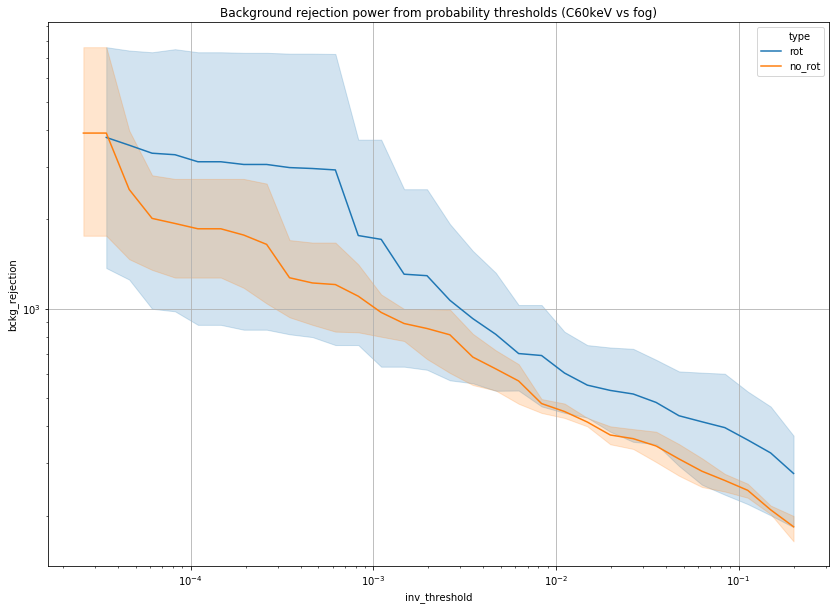

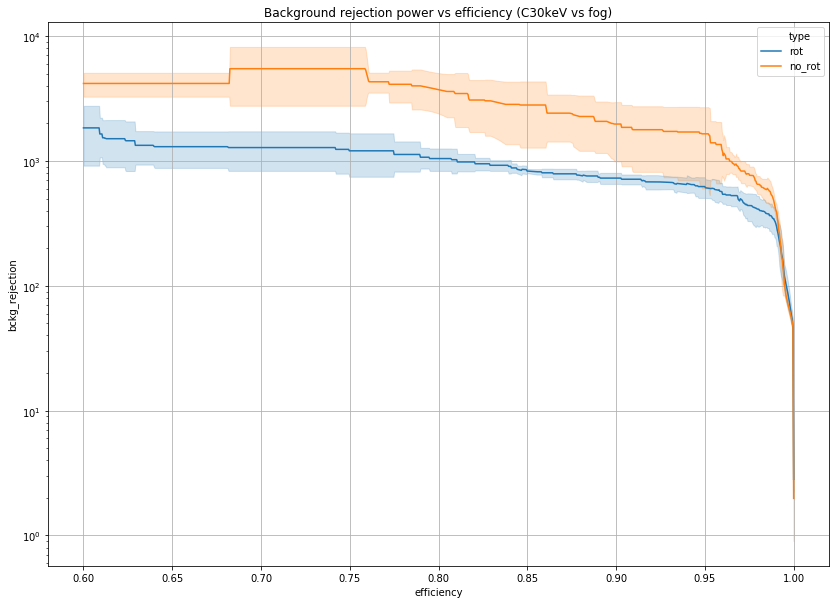




If we call inverse_threshold = 1-threshold to explore the region of probability threshold close to 1




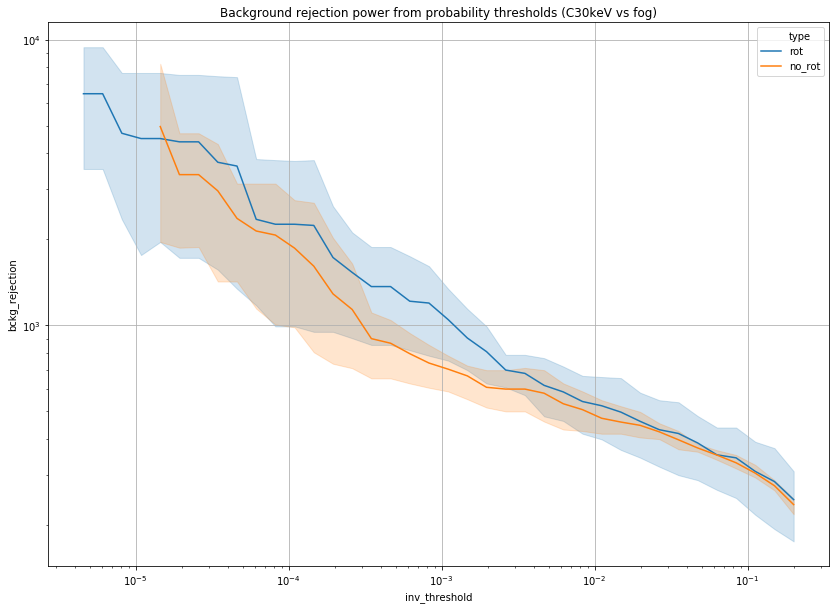

In [17]:
for n in class_names:
    # n is a class (==model)
    #if not any([n in s for s in load_s]): continue
    
    plt.figure(figsize=(14,10))
    sns.lineplot(x='efficiency',y='bckg_rejection',hue='type', data=pr_curves[pr_curves['class']==n], ci='sd')
    plt.grid()
    plt.yscale('log')
    #plt.xscale('logit')
    plt.title('Background rejection power vs efficiency ('+n+' vs fog)')
    plt.show()   

    print('\n\n\nIf we call inverse_threshold = 1-threshold to explore the region of probability threshold close to 1\n\n')
    
    plt.figure(figsize=(14,10))
    sns.lineplot(x='inv_threshold',y='bckg_rejection',hue='type', data=thr_curves[thr_curves['class']==n])
    plt.grid()
    plt.yscale('log')
    plt.xscale('log')
    plt.title('Background rejection power from probability thresholds ('+n+' vs fog)')
    plt.show()
    
    print('\n\n')

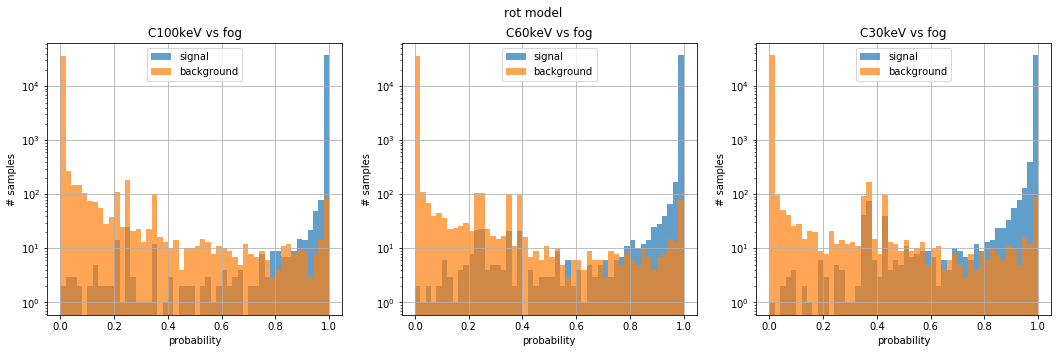

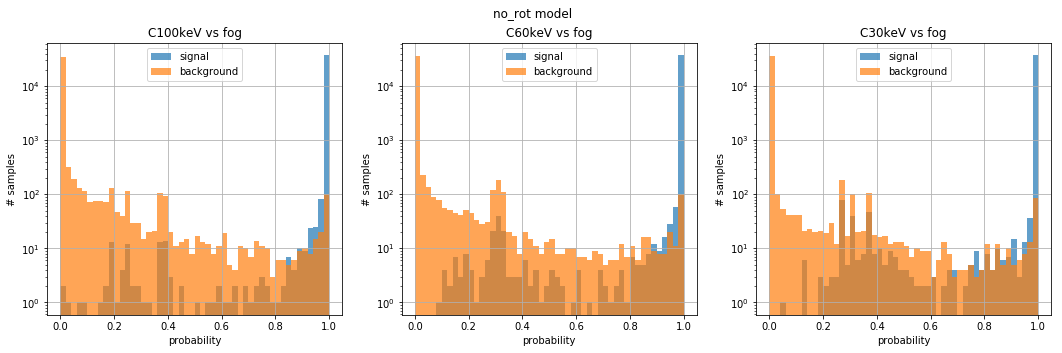

In [105]:
for tr in train_types:
    pred_mean, pos, neg = {},{},{}
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, k in enumerate(class_names):
        n=k
        #if k!='C100keV': continue
        pos[k+'_'+n+'_'+tr], neg[k+'_'+n+'_'+tr] = np.zeros((0,2)), np.zeros((0,2))
        for s in [m for m in load_s if n in m]:
            pos[k+'_'+s+'_'+tr], neg[k+'_'+s+'_'+tr] = pos_neg(preds[k+'_'+s+'_'+tr][:,1], preds[k+'_'+s+'_'+tr][:,0])
            pos[k+'_'+n+'_'+tr] = np.vstack((pos[k+'_'+n+'_'+tr],pos[k+'_'+s+'_'+tr]))
            neg[k+'_'+n+'_'+tr] = np.vstack((neg[k+'_'+n+'_'+tr],neg[k+'_'+s+'_'+tr]))
        axes[i].hist(pos[k+'_'+n+'_'+tr][:,0], bins=50, alpha=0.7, label='signal', range=(0,1))
        axes[i].hist(neg[k+'_'+n+'_'+tr][:,0], bins=50, alpha=0.7, label='background', range=(0,1))
        axes[i].grid()
        axes[i].set_title(k+' vs fog')
        axes[i].set_yscale('log')
        axes[i].set_ylabel('# samples')
        axes[i].set_xlabel('probability')
        axes[i].legend(loc=9)
    plt.suptitle(tr+' model')
    plt.show()

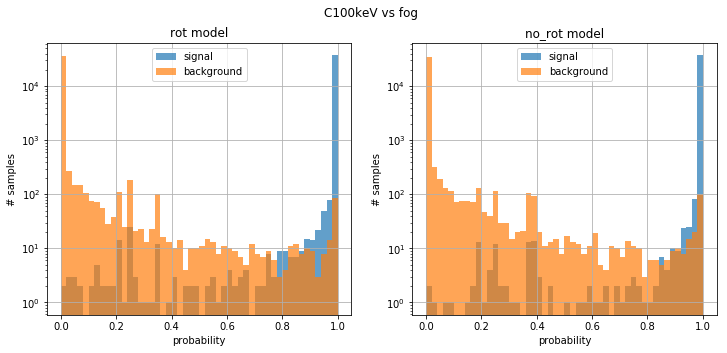

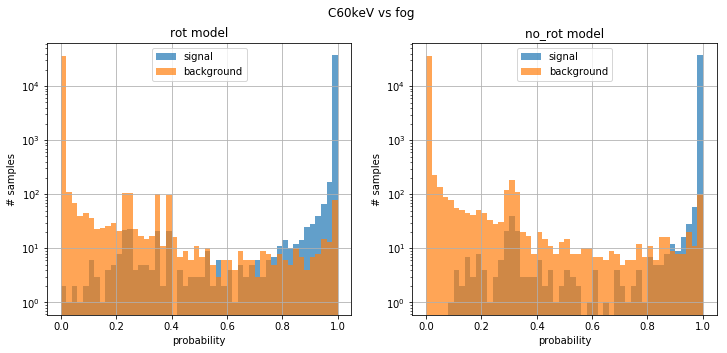

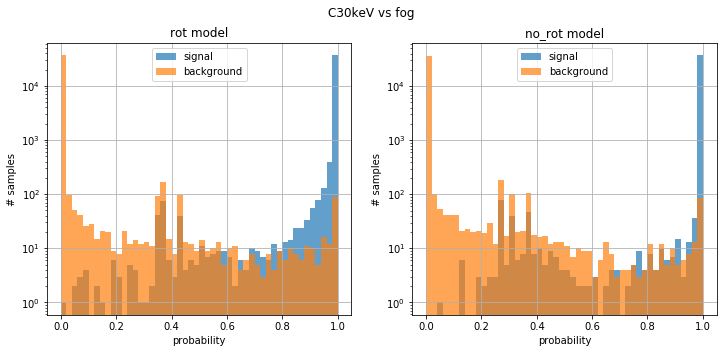

In [40]:
for k in class_names:
    pred_mean, pos, neg = {},{},{}
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for i, tr in enumerate(train_types):
        n=k
        #if k!='C100keV': continue
        pos[k+'_'+n+'_'+tr], neg[k+'_'+n+'_'+tr] = np.zeros((0,2)), np.zeros((0,2))
        for s in [m for m in load_s if n in m]:
            pos[k+'_'+s+'_'+tr], neg[k+'_'+s+'_'+tr] = pos_neg(preds[k+'_'+s+'_'+tr][:,1], preds[k+'_'+s+'_'+tr][:,0])
            pos[k+'_'+n+'_'+tr] = np.vstack((pos[k+'_'+n+'_'+tr],pos[k+'_'+s+'_'+tr]))
            neg[k+'_'+n+'_'+tr] = np.vstack((neg[k+'_'+n+'_'+tr],neg[k+'_'+s+'_'+tr]))
        axes[i].hist(pos[k+'_'+n+'_'+tr][:,0], bins=50, alpha=0.7, label='signal', range=(0,1))
        axes[i].hist(neg[k+'_'+n+'_'+tr][:,0], bins=50, alpha=0.7, label='background', range=(0,1))
        axes[i].grid()
        axes[i].set_title(tr+' model')
        axes[i].set_yscale('log')
        axes[i].set_ylabel('# samples')
        axes[i].set_xlabel('probability')
        axes[i].legend(loc=9)
    plt.suptitle(k+' vs fog')
    plt.show()